**Predicting Subscription Habits based on Age and Played Hours in a Minecraft Server**

Samantha Cham, Daha Choi, Trini Laughlen, and Madeline Miles

Introduction

*Methods*

In [18]:
#load libraries needed
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

#set the seed to make the process reproducible
set.seed(2025)

#read in data
players<-read_csv('https://raw.githubusercontent.com/madeline1312/toy_ds_project/refs/heads/main/players.csv')|>
mutate(subscribe=as_factor(subscribe))|>#made as a factor so we can build our classification model
select(Age, played_hours, subscribe)|># We can see NA's in the data, so we have to remove them to bind_cols later
drop_na()
players

#Now we will build out model
#Let's seperate the data into training and testing data sets
players_split<-players|>
initial_split(prop=0.6, strata=subscribe)
players_train<-training(players_split)
players_test<-testing(players_split)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,TRUE
17,3.8,TRUE
17,0.0,FALSE
⋮,⋮,⋮
22,0.3,FALSE
17,0.0,FALSE
17,2.3,FALSE


mean,neighbors
<dbl>,<dbl>
0.6467391,9
0.6293478,10


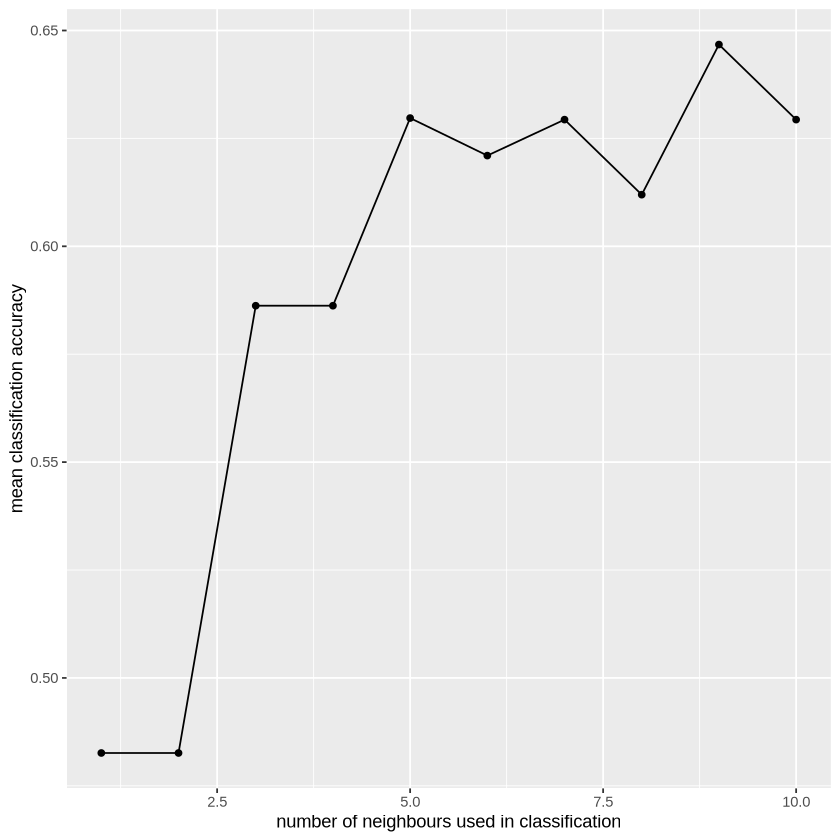

In [19]:
set.seed(2025)
#Build the model, initally use tune until the best k value is found. 
knn_tune<-nearest_neighbor(weight_func='rectangular',neighbors=tune())|>
set_engine('kknn')|>
set_mode('classification')

players_recipe<-recipe(subscribe~Age+played_hours, data=players_train)|>
step_center(all_predictors())|>
step_scale(all_predictors())

workflow<-workflow()|>
add_recipe(players_recipe)|>
add_model(knn_tune)

players_vfold<-vfold_cv(players_train, v=5, strata=subscribe)

players_table<-tibble(neighbors=seq(from=1, to=10, by=1))

knn_results<-workflow|>
tune_grid(resample=players_vfold, grid=players_table)|>
collect_metrics()|>
filter(.metric=='accuracy')

cross_val_plot<-knn_results|>
ggplot(aes(y=mean, x=neighbors))+
geom_point()+
geom_line()+
labs(y="mean classification accuracy", x="number of neighbours used in classification")
cross_val_plot
#This plot shows that the best k value to use for this project is k=9, becasue it has the best accuracy.

In [20]:
set.seed(2025)
#build the model with k=9 to have the best accuracy
players_knn<-nearest_neighbor(weight_func='rectangular', neighbors=9)|>
set_mode('classification')|>
set_engine('kknn')

players_workflow<-workflow()|>
add_recipe(players_recipe)|>
add_model(players_knn)|>
fit(data=players_train)


In [26]:
set.seed(2025)
#test the model to see if it is accurate with the testing data
knn_accuracy<-players_workflow|>
predict(players_test)|> 
bind_cols(players_test)|>
metrics(truth=subscribe, estimate=.pred_class)|>
filter(.metric=="accuracy")|>
pull()

knn_accuracy


[1] 0.5769231

Results

Discussion